In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from scipy.fftpack import dct, idct
from skimage import data

plt.gray()
%matplotlib inline

# Filtering with transformations
One observation that one can make when experimenting with images is that much of the detail is captured in the low frequency components. If we take the DCT of a (non-noisy) image, then we expect that the high frequency components will cature more of the detail in the image, such as edges, while the low-frequency components will have more information about the general structure. We can see this in the plot of the DCT spectrum of this image, where the values in the upper left corner are lower frequency. This plot is on a log scale, so it is difficult to see a sharp difference, but the magnitude is indeed higher on average in the top left.

Below that, we can see low and high pass filters applied to the cameraman image. The low pass filter captures most of the general shape, and with passing only 40 bands (less than 1/100 of the size of the total image), we can easily identify the image. When looking at the high pass components, we can identify the outline, or edges of the cameraman quite easily.

In [5]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')
def gnoise(a, sig):
    return np.clip(a+sig*np.random.randn(*a.shape), a.min(), a.max())
def spnoise(a, p):
    n = np.random.rand(*a.shape)
    l = n<p/2
    u = n>(1-p/2)
    return a * ~(l|u) + u*a.max()
def low_pass(im, n_pass, tr=None):
    if tr is None:
        tr = dct2(im)
    m = np.zeros_like(im)
    x, y=np.mgrid[:im.shape[0], :im.shape[1]]
    d = np.sqrt(x**2 + y**2)
    m[d<n_pass] = 1
    return idct2(tr*m)
def high_pass(im, n_pass, tr=None):
    if tr is None:
        tr = dct2(im)
    m = np.zeros_like(im)
    m[-n_pass:, -n_pass:] = 1
    return idct2(tr*m)
def band_pass(im, bounds):
    lb, ub = bounds # bounds= ((i,j), (k,l))
    tr = dct2(im)
    m = np.zeros_like(im)
    m[lb[0]:ub[0], lb[1]:ub[1]] = 1
    return idct2(tr*m)
def arb_pass(im, mask):
    return idct2(dct2(im)*mask)

In [6]:
im = data.camera() / 255.0

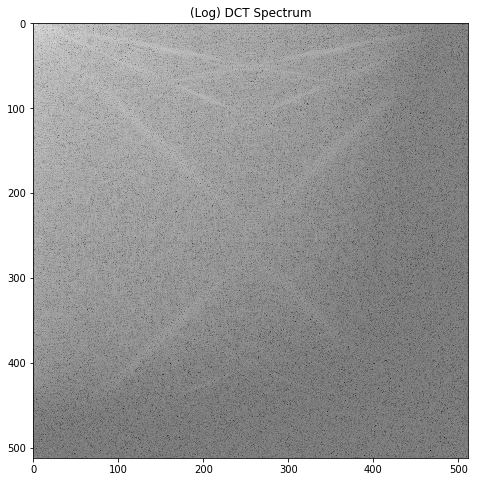

In [16]:
plt.figure(figsize=(8,8))
plt.title('(Log) DCT Spectrum')
di = dct2(im)
plt.imshow(np.log(np.abs(di)))

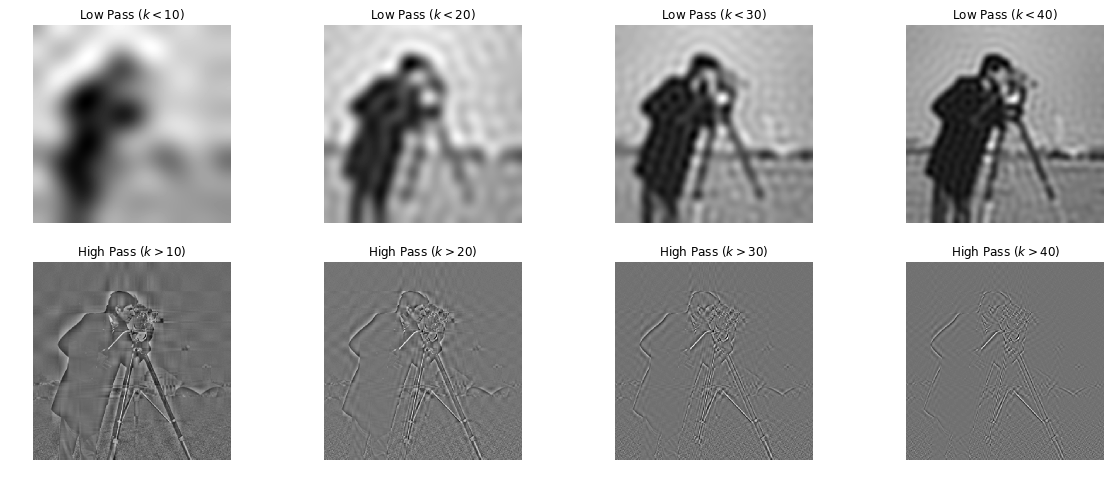

In [25]:
plt.figure(figsize=(20, 8))
for i in range(1, 5):
    ax = plt.subplot(2, 4, i)
    ax.imshow(low_pass(im, 10*i))
    ax.set_title('Low Pass ($k < %d$)'% (10*i))
    ax.axis('off')
for i in range(1, 5):
    ax = plt.subplot(2, 4, i+4)
    ax.imshow(high_pass(im, 512-10*i))
    ax.set_title('High Pass ($k > %d$)'% (10*i))
    ax.axis('off')

## Band Pass Filters
Below we can see band pass filters passing the bands corrresponding to their position in the grid. This means that the first one passes the rectangle with corners at (0,0) to (63, 63), and in general, the $i$th row and $j$th column corresponds to passing frequencies from $(64i, 64j)$ through $(64(i+1), 64(j+1))$

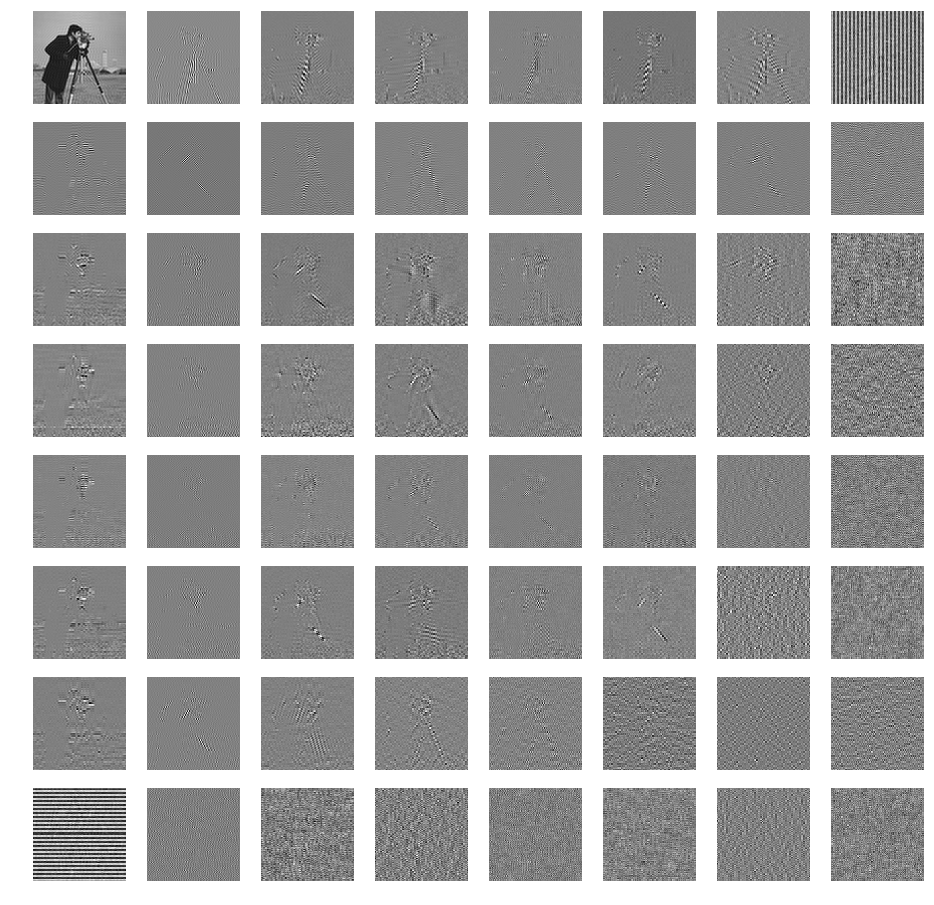

In [24]:
plt.figure(figsize=(16, 16))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, 8*i+j+1)
        ub = (64*(i+1), 64*(j+1))
        lb = (64*i, 64*j)
        ax.imshow(band_pass(im, (lb, ub)))
        ax.axis('off')

## Noisy images
We can imagine that if we add noise to an image, it would be a high-frequency signal, so we could remove it by applying a low pass filter.

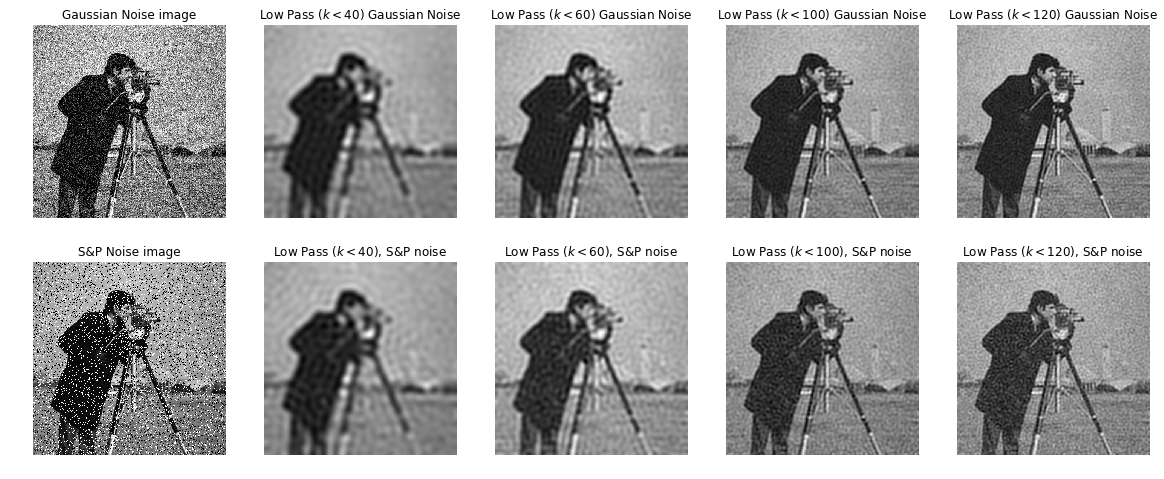

In [39]:
plt.figure(figsize=(20, 8))
ssseeeeddd = 182938
np.random.seed(ssseeeeddd)
nim = gnoise(im, 0.2)

ax = plt.subplot(2, 5, 1)
ax.imshow(nim)
ax.set_title('Gaussian Noise image')
ax.axis('off')

passes = [40, 60, 100, 120]
for i, k in enumerate(passes):
    ax = plt.subplot(2, 5, i+2)
    ax.imshow(low_pass(nim, k))
    ax.set_title('Low Pass ($k < %d$) Gaussian Noise'% (k))
    ax.axis('off')
    
nim2 = spnoise(im, 0.2)
ax = plt.subplot(2, 5, 6)
ax.imshow(nim2)
ax.set_title('S&P Noise image')
ax.axis('off')

for i, k in enumerate(passes):
    ax = plt.subplot(2, 5, 4+i+3)
    ax.imshow(low_pass(nim2, k))
    ax.set_title('Low Pass ($k < %d$), S&P noise'% (k))
    ax.axis('off')

In [32]:
gnoisy_errs = []
spnoisy_errs = []
errs = []

tr = dct2(im)
trg = dct2(nim)
trs = dct2(nim2)

for i in range(im.shape[1]+1):
    errs.append(np.sqrt(((low_pass(im, i, tr) - im)**2).mean()))
    gnoisy_errs.append(np.sqrt(((low_pass(nim, i, trg) - im)**2).mean()))
    spnoisy_errs.append(np.sqrt(((low_pass(nim2, i, trs) - im)**2).mean()))

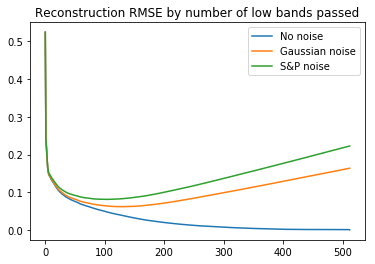

In [34]:
plt.title('Reconstruction RMSE by number of low bands passed')
plt.plot(errs, label='No noise')
plt.plot(gnoisy_errs, label='Gaussian noise')
plt.plot(spnoisy_errs, label='S&P noise')
plt.legend(loc='best')

Observe that this reconstruction error rapidly decreases at first in the noisy image, supporting the notion that low frequencies capture most of the image structure. In addition, we can see that as we pass more bands, the error on the noisy images decreases at first, then increase after 100 or so, demonstrating the effectiveness of such a method for eliminating noise from images

## Wavelets
Here, I experiment with Haar wavelets in a similar manner as above. The idea behind Haar wavelets is that any function can be represented by transforms of the mother wavelet function $\psi$, which takes on 1 if x is between 0 and 1/2, takes on -1 if x is between 1/2 and 1, and zero otherwise. We can then take functions of the form $2^{n/2}\psi(2^n x-k)$, which serve as an orthogonal basis for continuous real functions. We can see that these result in a slightly worse decomposition than the DCT, but is comparable. We measure the reconstruction error for filters with only the lowest decomposition retained (the LL one)

In [40]:
import pywt

In [104]:
haar_errs = [0.0]
shapes = [512]
for l in range(1, 10):
    cs = pywt.wavedec2(im, 'haar', level=l)
    shapes.append(cs[0].shape[0])
    cs = [cs[0]] + [(None, None, None)] *(len(cs)-1)
    rec = pywt.waverec2(cs, 'haar')
    rec_err = np.sqrt(((rec-im)**2).mean())
    haar_errs.append(rec_err)

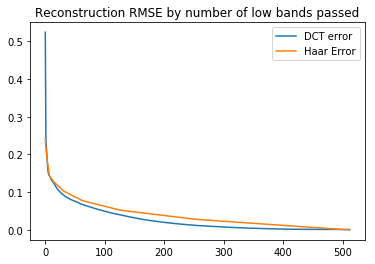

In [105]:
plt.title('Reconstruction RMSE by number of low bands passed')
plt.plot(errs, label='DCT error')
plt.plot(np.array(shapes)-1, haar_errs, label='Haar Error')
plt.legend(loc='best')